# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

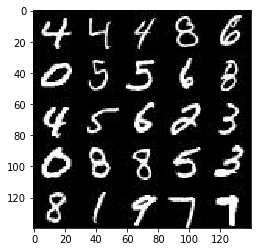

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

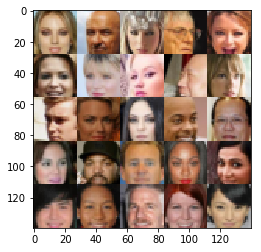

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='lr')
    return inputs_real, inputs_z, learning_rate
    #return None, None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*784)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 784))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.nn.relu(x1)
        # 7x7x784 now
        
        x2 = tf.layers.conv2d_transpose(x1, 392, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.relu(x2)
        # 14x14x196 now
        
        x3 = tf.layers.conv2d_transpose(x2, 196, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.relu(x3)
        # 28x28x98 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_channel now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
##Losses
def plot_losses(losses):
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()

In [20]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    tf.reset_default_graph()
        
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        print ("Before training start, images from noise:")
        gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})           
        if data_image_mode == 'L':
            pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode), cmap='gray')
        else:
            pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode))
        pyplot.show()
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                x = batch_images
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: x, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: x})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    #samples.append(gen_samples)
                    #pyplot.imshow(helper.images_square_grid(samples, 'RGB'))
                    #_ = view_samples(-1, samples, 5, 5, figsize=(5,5))
                    if data_image_mode == 'L':
                        pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode), cmap='gray')
                    else:
                        pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode))
                    pyplot.show()
        
        # FInal image
        gen_samples = sess.run(generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})           
        if data_image_mode == 'L':
            pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode), cmap='gray')
        else:
            pyplot.imshow(helper.images_square_grid(gen_samples[:25], data_image_mode))
        pyplot.show()
        plot_losses(losses)
        #saver.save(sess, './generator.ckpt')


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Before training start, images from noise:


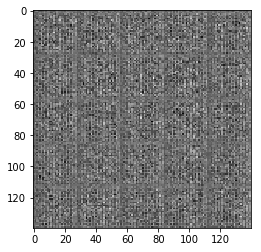

Epoch 1/2... Discriminator Loss: 2.5631... Generator Loss: 0.1134
Epoch 1/2... Discriminator Loss: 2.1108... Generator Loss: 0.1876
Epoch 1/2... Discriminator Loss: 2.2199... Generator Loss: 0.2497
Epoch 1/2... Discriminator Loss: 2.1484... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 1.9466... Generator Loss: 0.4329
Epoch 1/2... Discriminator Loss: 1.8433... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.8191... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.6066
Epoch 1/2... Discriminator Loss: 1.6896... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.4895... Generator Loss: 0.6224


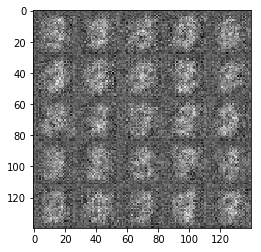

Epoch 1/2... Discriminator Loss: 1.4649... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.4633... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.6106
Epoch 1/2... Discriminator Loss: 1.3282... Generator Loss: 0.7038
Epoch 1/2... Discriminator Loss: 1.3648... Generator Loss: 0.7136
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.6923
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.7056


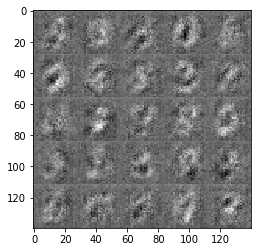

Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.3062... Generator Loss: 0.7683
Epoch 1/2... Discriminator Loss: 1.2097... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.2094... Generator Loss: 0.7809
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.8614
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 0.8995
Epoch 1/2... Discriminator Loss: 1.0853... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.0614... Generator Loss: 0.9153
Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.9437... Generator Loss: 0.9891


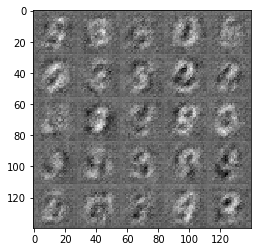

Epoch 1/2... Discriminator Loss: 1.0393... Generator Loss: 0.9111
Epoch 1/2... Discriminator Loss: 0.8721... Generator Loss: 1.0771
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 0.7688... Generator Loss: 1.2770
Epoch 1/2... Discriminator Loss: 0.6830... Generator Loss: 1.4631
Epoch 1/2... Discriminator Loss: 0.9023... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 0.7809... Generator Loss: 1.2996
Epoch 1/2... Discriminator Loss: 0.8815... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 0.7315... Generator Loss: 1.1499
Epoch 1/2... Discriminator Loss: 0.7902... Generator Loss: 1.0624


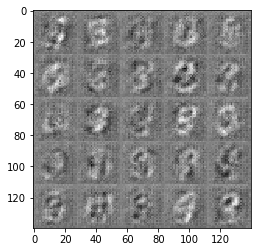

Epoch 1/2... Discriminator Loss: 0.6479... Generator Loss: 1.4682
Epoch 1/2... Discriminator Loss: 0.9005... Generator Loss: 1.1637
Epoch 1/2... Discriminator Loss: 0.8948... Generator Loss: 1.0095
Epoch 1/2... Discriminator Loss: 0.6618... Generator Loss: 1.7670
Epoch 1/2... Discriminator Loss: 0.8923... Generator Loss: 0.7150
Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 0.7101... Generator Loss: 1.4263
Epoch 2/2... Discriminator Loss: 0.6341... Generator Loss: 1.4045
Epoch 2/2... Discriminator Loss: 0.7506... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 0.7569... Generator Loss: 1.8357


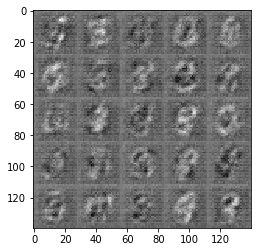

Epoch 2/2... Discriminator Loss: 0.7226... Generator Loss: 1.1394
Epoch 2/2... Discriminator Loss: 0.8390... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 0.5796... Generator Loss: 1.6894
Epoch 2/2... Discriminator Loss: 0.6899... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 0.7110... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 0.5911... Generator Loss: 2.0781
Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.6619
Epoch 2/2... Discriminator Loss: 0.5877... Generator Loss: 1.6399
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.9673


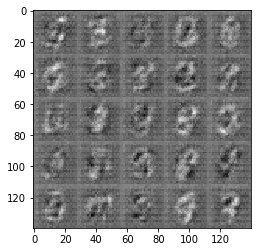

Epoch 2/2... Discriminator Loss: 0.7851... Generator Loss: 0.8567
Epoch 2/2... Discriminator Loss: 0.5932... Generator Loss: 1.4917
Epoch 2/2... Discriminator Loss: 0.4789... Generator Loss: 1.8518
Epoch 2/2... Discriminator Loss: 0.6629... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 2.0449
Epoch 2/2... Discriminator Loss: 0.6617... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 0.5135... Generator Loss: 2.0322
Epoch 2/2... Discriminator Loss: 0.4552... Generator Loss: 1.6835
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.2728
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 2.2113


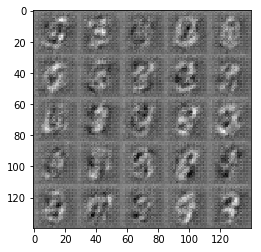

Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.5028
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 1.8619
Epoch 2/2... Discriminator Loss: 0.5512... Generator Loss: 1.3805
Epoch 2/2... Discriminator Loss: 0.5536... Generator Loss: 1.6949
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 1.2910
Epoch 2/2... Discriminator Loss: 0.4797... Generator Loss: 1.6293
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 1.9166
Epoch 2/2... Discriminator Loss: 0.4268... Generator Loss: 1.6801
Epoch 2/2... Discriminator Loss: 0.5624... Generator Loss: 1.5526


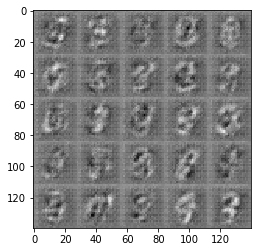

Epoch 2/2... Discriminator Loss: 0.4280... Generator Loss: 1.8072
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 1.6855
Epoch 2/2... Discriminator Loss: 0.5209... Generator Loss: 1.4169
Epoch 2/2... Discriminator Loss: 0.3967... Generator Loss: 1.7992
Epoch 2/2... Discriminator Loss: 0.5416... Generator Loss: 1.5897
Epoch 2/2... Discriminator Loss: 0.3738... Generator Loss: 1.9267
Epoch 2/2... Discriminator Loss: 0.3710... Generator Loss: 2.0645
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 1.6460
Epoch 2/2... Discriminator Loss: 0.4754... Generator Loss: 2.0011
Epoch 2/2... Discriminator Loss: 0.3986... Generator Loss: 1.7612


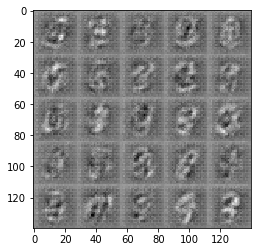

Epoch 2/2... Discriminator Loss: 0.4517... Generator Loss: 1.7388
Epoch 2/2... Discriminator Loss: 0.3798... Generator Loss: 1.8416
Epoch 2/2... Discriminator Loss: 0.5017... Generator Loss: 1.8627


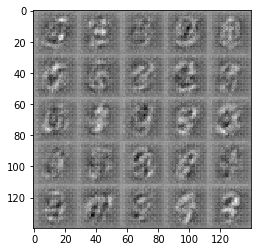

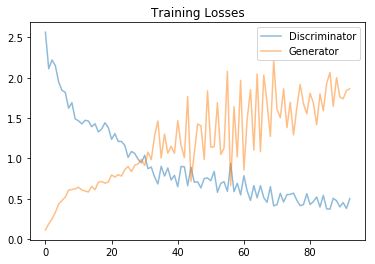

Iterations end


In [21]:
batch_size = 128
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
try:
    with tf.Graph().as_default():
        train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
              mnist_dataset.shape, mnist_dataset.image_mode)
except:
    print("Iterations end")

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

## Attempt 1
batch_size = 128

z_dim = 100

learning_rate = 0.0002

beta1 = 0.5


## Attempt 2
batch_size = 128

z_dim = 100

learning_rate = 0.00005

beta1 = 0.5


## Attempt 3
batch_size = 128

z_dim = 100

learning_rate = 0.00002

beta1 = 0.5


Before training start, images from noise:


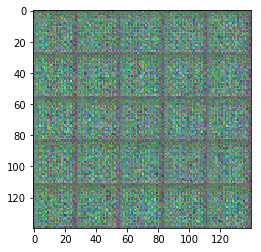

Epoch 1/1... Discriminator Loss: 2.1979... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 2.0157... Generator Loss: 0.2453
Epoch 1/1... Discriminator Loss: 2.2866... Generator Loss: 0.2032
Epoch 1/1... Discriminator Loss: 1.5656... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.8666... Generator Loss: 0.3158
Epoch 1/1... Discriminator Loss: 1.7880... Generator Loss: 0.3975
Epoch 1/1... Discriminator Loss: 1.5820... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.4216... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6391


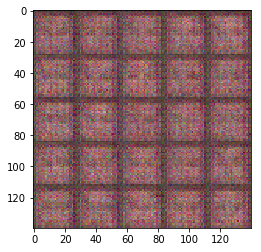

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.9446
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 0.9551
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.8879
Epoch 1/1... Discriminator Loss: 1.1297... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9928


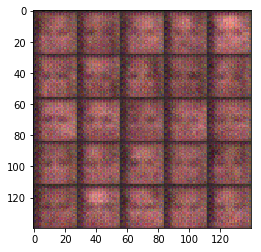

Epoch 1/1... Discriminator Loss: 1.7508... Generator Loss: 0.6140
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 0.8656
Epoch 1/1... Discriminator Loss: 1.5573... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.8895
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.9380


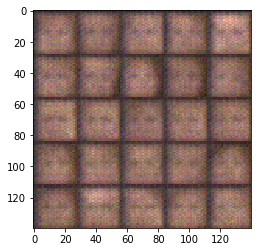

Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.7760
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.9183
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8679
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 0.9916
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 0.8283... Generator Loss: 1.4420
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 0.8504


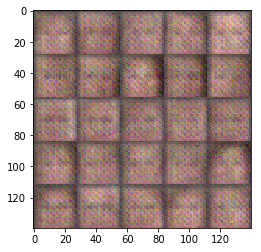

Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.3588
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6498
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.0852
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7782


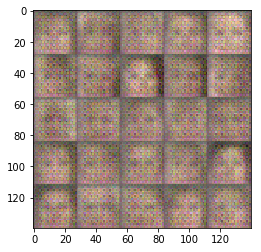

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 1.0298
Epoch 1/1... Discriminator Loss: 0.9999... Generator Loss: 1.0976
Epoch 1/1... Discriminator Loss: 1.6308... Generator Loss: 0.4413
Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.2533
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.5178... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 0.9083... Generator Loss: 1.7656
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.1383


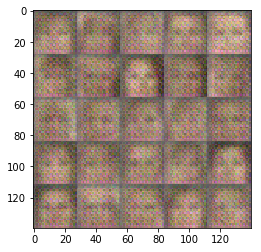

Epoch 1/1... Discriminator Loss: 1.5637... Generator Loss: 0.6119
Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 1.7899
Epoch 1/1... Discriminator Loss: 1.5012... Generator Loss: 0.5658
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.4714... Generator Loss: 0.6610
Epoch 1/1... Discriminator Loss: 0.9821... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.0921... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7923


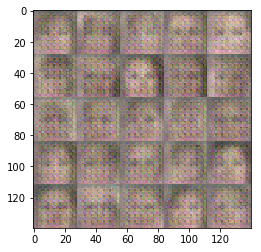

Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.0209... Generator Loss: 1.4473
Epoch 1/1... Discriminator Loss: 1.2275... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.0584
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9619


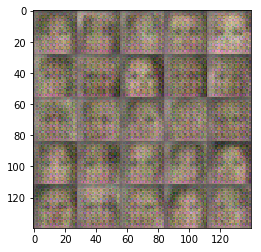

Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 1.4469
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3175... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.3129... Generator Loss: 0.8843


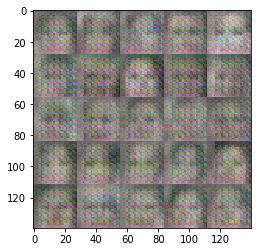

Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9091
Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 0.9238... Generator Loss: 1.0320
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.0911... Generator Loss: 1.0187
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.4672
Epoch 1/1... Discriminator Loss: 1.4845... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6763
Epoch 1/1... Discriminator Loss: 1.2151... Generator Loss: 0.8153


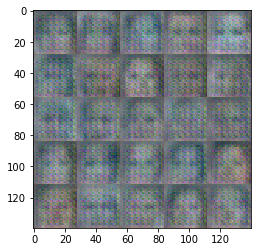

Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.5079
Epoch 1/1... Discriminator Loss: 0.7151... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.8859


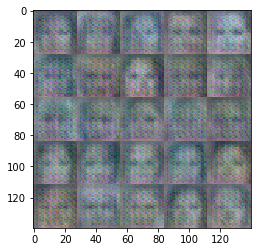

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.6192
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 0.5589... Generator Loss: 1.5375
Epoch 1/1... Discriminator Loss: 0.5653... Generator Loss: 2.6801
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.2313
Epoch 1/1... Discriminator Loss: 0.5850... Generator Loss: 1.7981
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.7340


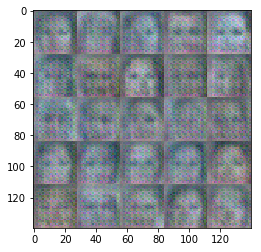

Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 0.8180... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 2.2689
Epoch 1/1... Discriminator Loss: 0.8466... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.3217... Generator Loss: 0.4444
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 1.1754
Epoch 1/1... Discriminator Loss: 1.5767... Generator Loss: 0.4004
Epoch 1/1... Discriminator Loss: 0.4601... Generator Loss: 2.7591
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.5286


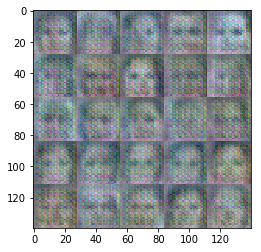

Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.4284
Epoch 1/1... Discriminator Loss: 0.7761... Generator Loss: 1.1903
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.5565... Generator Loss: 0.5174
Epoch 1/1... Discriminator Loss: 1.6966... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 1.4255... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.7411... Generator Loss: 3.0056
Epoch 1/1... Discriminator Loss: 1.5306... Generator Loss: 0.5597
Epoch 1/1... Discriminator Loss: 0.5262... Generator Loss: 3.3804


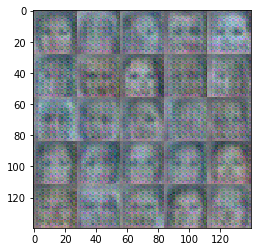

Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 1.0389
Epoch 1/1... Discriminator Loss: 1.6745... Generator Loss: 0.3463
Epoch 1/1... Discriminator Loss: 0.6929... Generator Loss: 3.9276
Epoch 1/1... Discriminator Loss: 0.3155... Generator Loss: 4.3043
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.6064... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 0.4149... Generator Loss: 4.3946
Epoch 1/1... Discriminator Loss: 0.6005... Generator Loss: 2.9301
Epoch 1/1... Discriminator Loss: 0.5993... Generator Loss: 2.1121
Epoch 1/1... Discriminator Loss: 0.5732... Generator Loss: 1.8054


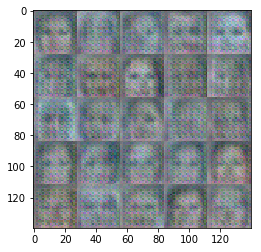

Epoch 1/1... Discriminator Loss: 0.5423... Generator Loss: 1.4980
Epoch 1/1... Discriminator Loss: 0.6671... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 1.9210... Generator Loss: 0.2410
Epoch 1/1... Discriminator Loss: 0.9329... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 2.0067... Generator Loss: 0.2095
Epoch 1/1... Discriminator Loss: 0.3800... Generator Loss: 3.0589
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.9643
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.4136


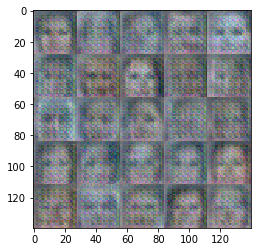

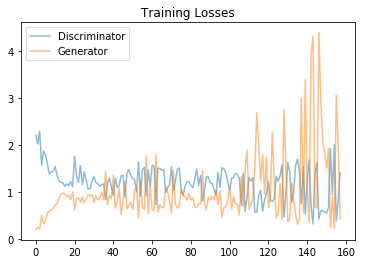

Iterations end


In [22]:
batch_size = 128
z_dim = 100
learning_rate = 0.00002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
try:
    with tf.Graph().as_default():
        train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
              celeba_dataset.shape, celeba_dataset.image_mode)
except:
    print("Iterations end")

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.